<a href="https://colab.research.google.com/github/rajeshpahari/Deep-Learning/blob/main/Pytorch_L2_Regularizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [33]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Data preperations- Loding , converting in tensor using dataloader

In [34]:
#Import data from seaborn Library
df=sns.load_dataset('iris')
#examine datframe
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [35]:
#Load all features in a tensor
data=torch.tensor(df[df.columns[0:4]].values).float()

#Load Targets in a tensor
labels=torch.zeros(len(data),dtype=torch.long)
labels[df.species=='versicolor']=1
labels[df.species=='virginica']=2

#Split Data in training and testing
train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size=0.2)

#convert data in a Train and test tensor..combining features & Targets
train_data=TensorDataset(train_data,train_label)
test_data=TensorDataset(test_data,test_label)

#Devide train data in batches and keep test data in one batch
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


# Create Model 

In [36]:
from torch.nn.modules import loss
from torch.nn.modules.linear import Linear
def CreateModel(l2lambda):

  #Model Architecture
  ANNclass=nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
  )

  #Loss function
  lossfunc=nn.CrossEntropyLoss()

  #Optimizer
  optimizer=torch.optim.SGD(ANNclass.parameters(),lr=.01,weight_decay=l2lambda)

  #return
  return ANNclass,lossfunc,optimizer


# Training Model

In [37]:

#No. Of epochs
numepochs=500

#Train Model

def trainModel():

  trainacc=[]
  testacc=[]
  losses=[]

  for epochsi in range(numepochs):

    #Define Batch accuracy
    batchacc=[]
    batchloss=[]

    for X,y in train_loader:

      #Forward pass & Loss calculation
      yHat=ANNclass(X)
      loss=lossfunc(yHat,y)

      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #calculate training Accuracy in each batch
      batchacc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
      
      batchloss.append(loss.item())

      #End of Batch loop  ..go back to first loop
    
    # Calculate training accuracy for each epochs
    trainacc.append(np.mean(batchacc))
    losses.append(np.mean(batchloss))

    #Start testing
    ANNclass.eval()

    #Forward pass for whole testset
    X,y=next(iter(test_loader))
    testacc.append(100*torch.mean(((torch.argmax(ANNclass(X),axis=1))==y).float()))
    #ANNclass.train() # We can mention here as well ...EVEn dont need
    #End of All Epochs

  #return
  return trainacc,testacc,losses

      

# Run the Model

In [38]:
L2lambda=.01
ANNclass,lossfunc,optimizer=CreateModel(L2lambda)
trainacc,testacc,losses=trainModel()

# Show the Result

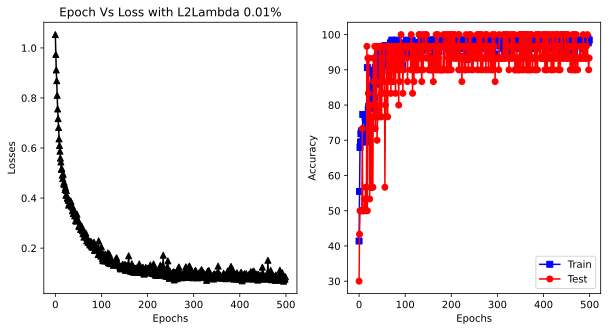

In [39]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses,'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')
ax[0].set_title('Epoch Vs Loss with L2Lambda %g%%'%L2lambda)

ax[1].plot(trainacc,'bs-')
ax[1].plot(testacc,'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train','Test'])

plt.show()


# Experiment with Varios lambda Values

In [40]:
#Smoothing Function
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [41]:
from types import LambdaType
L2lambdas=np.linspace(0,.1,10)

#Initialize output result Matrix
AccuracyTrain=np.zeros((numepochs,len(L2lambdas)))
AccuracyTest=np.zeros((numepochs,len(L2lambdas)))

#Loop for each lambda
for li in range(len(L2lambdas)):
  print(L2lambdas[li])

  ANNclass,lossfunc,optimizer=CreateModel(L2lambdas[li])
  trainacc,testacc,losses=trainModel()

  AccuracyTrain[:,li]=smooth(trainacc,10)
  AccuracyTest[:,li]=smooth(testacc,10)



0.0
0.011111111111111112
0.022222222222222223
0.03333333333333333
0.044444444444444446
0.05555555555555556
0.06666666666666667
0.07777777777777778
0.08888888888888889
0.1


# Plot the result

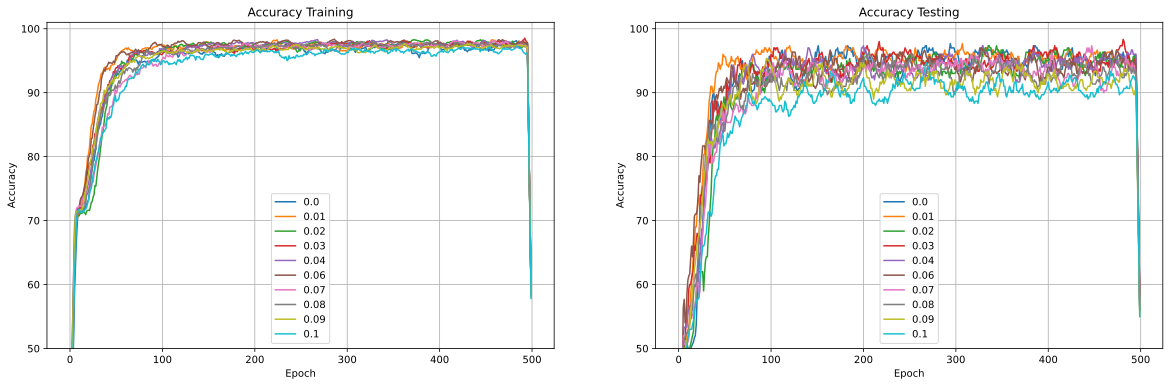

In [45]:
fig,ax=plt.subplots(1,2,figsize=(20,6))

ax[0].plot(AccuracyTrain)
ax[0].set_title('Accuracy Training')

ax[1].plot(AccuracyTest)
ax[1].set_title('Accuracy Testing')

#legends
leglabels=[np.round(i,2) for i in L2lambdas]

for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

